In [2]:
import pandas as pd
import polars as pl
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import npc_lims
# from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import spike_utils
from dynamic_routing_analysis import data_utils

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
import pickle
import upath

%load_ext autoreload
%autoreload 2
# %matplotlib widget

In [3]:
# get list of sessions to run on
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_good_behavior').eq(True),
    pl.col('is_engaged').eq(True),
    )['session_id'].to_list()
    )

In [5]:
len(dr_session_list)

93

In [4]:
#structure remapping
grouping = {
        'SCop': 'SCs','SCsg': 'SCs','SCzo': 'SCs',
        'SCig': 'SCm','SCiw': 'SCm','SCdg': 'SCm','SCdw': 'SCm',
        "ECT1": 'ECT',"ECT2/3": 'ECT',"ECT6b": 'ECT',"ECT5": 'ECT',"ECT6a": 'ECT',"ECT4": 'ECT',
        
    }

In [22]:
# useful functions


#generate ITIs with same statistics as the task

def generate_DR_ITI(n_samples=None,is_templeton=False):

    import random

    preStimFramesFixed = 90 # min frames between start of trial and stimulus onset
    preStimFramesVariableMean = 60 # mean of additional preStim frames drawn from exponential distribution
    preStimFramesMax = 360 # max total preStim frames
    responseWindow = [6,60]
    postResponseWindowFrames = 180

    if is_templeton:
        preStimFramesVariableMean = 30 
        preStimFramesMax = 240
        postResponseWindowFrames = 120

    if n_samples is not None:
        return [generate_DR_ITI() for _ in range(n_samples)]
    else:
        val = preStimFramesFixed + random.expovariate(1/preStimFramesVariableMean) if preStimFramesVariableMean > 1 else preStimFramesFixed + preStimFramesVariableMean
        trial_total_length = (int(min(val,preStimFramesMax)) + responseWindow[1] + postResponseWindowFrames)/60 #in seconds

        return trial_total_length
    

def compute_lda_projections(session_id, version='0.0.272', time_before_stimulus=1.5, binsize=1.5):

    epochs=pd.read_parquet(npc_lims.get_cache_path(nwb_component='epochs', session_id=session_id, version=version))
    if 'Spontaneous' not in epochs['script_name'].values:
        print(f"Session {session_id} has no spontaneous epochs, skipping.")
        return None

    session_info=npc_lims.get_session_info(session_id)
    trials=data_utils.load_trials_or_units(session_info, 'trials', version=version)
    units=data_utils.load_trials_or_units(session_info, 'units', version=version)
    
    #make data array
    units_filtered = units.query(
        'presence_ratio>=0.7 and \
        isi_violations_ratio<=0.5 and \
        amplitude_cutoff<=0.1 and \
        activity_drift<=0.2 and \
        firing_rate>=0.5 and \
        ~structure.isna() and ~location.isna()'
        ).sort_values(['electrode_group_name', 'peak_channel', 'unit_id'])

    time_before = time_before_stimulus
    time_after = 0.01
    binsize = binsize
    trial_da = spike_utils.make_neuron_time_trials_tensor(units_filtered, trials, time_before, time_after, binsize)

    task_index=epochs.query('script_name=="DynamicRouting1"').index[0]

    #make spontaneous trials data array
    spont_trials={
        'start_time':[],
    }

    for rr,row in epochs.query('script_name.str.contains("Spontaneous") and id<@task_index').iterrows():
        spont_start=row['start_time']
        spont_end=row['stop_time']
        spont_duration=spont_end-spont_start
        
        sampleITIs=generate_DR_ITI(n_samples=1000,is_templeton=False)
        cum_sampleITIs=np.cumsum(sampleITIs)
        valid_starts=spont_start+cum_sampleITIs[cum_sampleITIs+spont_start<spont_end]

        spont_trials['start_time'].append(valid_starts)

    spont_trials['start_time'] = np.concatenate(spont_trials['start_time'])
    spont_trials_df = pd.DataFrame(spont_trials)
    time_before = time_before_stimulus
    time_after = 0.01
    binsize = binsize
    spont_trial_da = spike_utils.make_neuron_time_trials_tensor(units_filtered, spont_trials_df, time_before, time_after, binsize, event_name='start_time')

    #run LDA per structure, save projections of task and spont trials
    structure_lda_results={
        'structure':[],
        'task_projection':[],
        'spont_projection':[],
        'task_projection_corrected':[],
    }

    #remap select structure names
    units_filtered['structure']=units_filtered['structure'].replace(grouping)

    structures=units_filtered['structure'].unique()
    for structure in structures:
        units_in_structure=units_filtered[units_filtered['structure']==structure]['unit_id'].unique()
        if len(units_in_structure)<10:
            continue
        
        structure_da=trial_da.sel(unit_id=units_in_structure)
        labels=trials['is_vis_rewarded']

        lda = LinearDiscriminantAnalysis(n_components=1) # Project to 1 dimension
        lda.fit(structure_da.data.reshape(structure_da.data.shape[0], -1).T, labels)

        task_projection = lda.transform(structure_da.data.reshape(structure_da.data.shape[0], -1).T).flatten()

        # project spontaneous activity onto context dimension
        spont_structure_da=spont_trial_da.sel(unit_id=units_in_structure)
        spont_projection = lda.transform(spont_structure_da.data.reshape(spont_structure_da.data.shape[0], -1).T).flatten()

        structure_lda_results['structure'].append(structure)
        structure_lda_results['task_projection'].append(task_projection)
        structure_lda_results['spont_projection'].append(spont_projection)

        # correct task projection by excluding instruction trials and removing blockwise mean
        block_idx=trials['block_index'].values
        instruction_trial_idx=trials['is_instruction'].values
        task_projection_corrected=task_projection.copy()
        task_projection_corrected[instruction_trial_idx]=np.nan #set instruction trials to nan
        for bidx in np.unique(block_idx):
            block_mean=np.mean(task_projection[block_idx==bidx])
            task_projection_corrected[block_idx==bidx]-=block_mean

        structure_lda_results['task_projection_corrected'].append(task_projection_corrected)

    structure_lda_results_df=pd.DataFrame(structure_lda_results)

    return structure_lda_results_df


def compute_pca_projections(session_id, version='0.0.272', time_before_stimulus=1.5, binsize=1.5):

    epochs=pd.read_parquet(npc_lims.get_cache_path(nwb_component='epochs', session_id=session_id, version=version))
    if 'Spontaneous' not in epochs['script_name'].values:
        print(f"Session {session_id} has no spontaneous epochs, skipping.")
        return None

    session_info=npc_lims.get_session_info(session_id)
    trials=data_utils.load_trials_or_units(session_info, 'trials', version=version)
    units=data_utils.load_trials_or_units(session_info, 'units', version=version)
    
    #make data array
    units_filtered = units.query(
        'presence_ratio>=0.7 and \
        isi_violations_ratio<=0.5 and \
        amplitude_cutoff<=0.1 and \
        activity_drift<=0.2 and \
        firing_rate>=0.5 and \
        ~structure.isna() and ~location.isna()'
        ).sort_values(['electrode_group_name', 'peak_channel', 'unit_id'])

    time_before = time_before_stimulus
    time_after = 0.01
    binsize = binsize
    trial_da = spike_utils.make_neuron_time_trials_tensor(units_filtered, trials, time_before, time_after, binsize)

    task_index=epochs.query('script_name=="DynamicRouting1"').index[0]

    #make spontaneous trials data array
    spont_trials={
        'start_time':[],
    }

    # for rr,row in epochs.query('script_name.str.contains("Spontaneous") and id<@task_index').iterrows():
    for rr,row in epochs.query('script_name=="Spontaneous" and id<@task_index').iterrows():
        spont_start=row['start_time']
        spont_end=row['stop_time']
        spont_duration=spont_end-spont_start
        
        sampleITIs=generate_DR_ITI(n_samples=1000,is_templeton=False)
        cum_sampleITIs=np.cumsum(sampleITIs)
        valid_starts=spont_start+cum_sampleITIs[cum_sampleITIs+spont_start<spont_end]

        spont_trials['start_time'].append(valid_starts)

    spont_trials['start_time'] = np.concatenate(spont_trials['start_time'])
    spont_trials_df = pd.DataFrame(spont_trials)
    time_before = time_before_stimulus
    time_after = 0.01
    binsize = binsize
    spont_trial_da = spike_utils.make_neuron_time_trials_tensor(units_filtered, spont_trials_df, time_before, time_after, binsize, event_name='start_time')

    #fit PCA per structure, save projections of task and spont trials
    structure_pca_results={
        'structure':[],
        'task_projection_on_task_PC1':[],
        'spont_projection_on_task_PC1':[],
        'task_projection_on_task_PC1_corrected':[],
        'task_projection_on_spont_PC1':[],
        'spont_projection_on_spont_PC1':[],
        'task_projection_on_spont_PC1_corrected':[],
    }

    #remap select structure names
    units_filtered['structure']=units_filtered['structure'].replace(grouping)

    structures=units_filtered['structure'].unique()
    for structure in structures:
        units_in_structure=units_filtered[units_filtered['structure']==structure]['unit_id'].unique()
        if len(units_in_structure)<10:
            continue
        
        structure_da=trial_da.sel(unit_id=units_in_structure)
        labels=trials['is_vis_rewarded']

        pca = PCA() # Project to 1 dimension
        scaler = StandardScaler()
        structure_da_scaled = scaler.fit_transform(structure_da.data.reshape(structure_da.data.shape[0], -1).T)
        pca.fit(structure_da_scaled)
        task_projection = pca.transform(structure_da_scaled)[:,0]

        # project spontaneous activity onto context dimension
        spont_structure_da=spont_trial_da.sel(unit_id=units_in_structure)
        spont_structure_da_scaled = scaler.transform(spont_structure_da.data.reshape(spont_structure_da.data.shape[0], -1).T)
        spont_projection = pca.transform(spont_structure_da_scaled)[:,0]

        structure_pca_results['structure'].append(structure)
        structure_pca_results['task_projection_on_task_PC1'].append(task_projection)
        structure_pca_results['spont_projection_on_task_PC1'].append(spont_projection)

        #project task and spont activity onto spont PC1
        spont_pca = PCA()
        spont_pca.fit(spont_structure_da_scaled)
        task_projection_on_spont_PC1 = spont_pca.transform(structure_da_scaled)[:,0]
        spont_projection_on_spont_PC1 = spont_pca.transform(spont_structure_da_scaled)[:,0]
        structure_pca_results['task_projection_on_spont_PC1'].append(task_projection_on_spont_PC1)
        structure_pca_results['spont_projection_on_spont_PC1'].append(spont_projection_on_spont_PC1)
        
        # correct task projection by excluding instruction trials and removing blockwise mean
        block_idx=trials['block_index'].values
        instruction_trial_idx=trials['is_instruction'].values
        task_projection_corrected=task_projection.copy()
        task_projection_corrected[instruction_trial_idx]=np.nan #set instruction trials to nan
        task_projection_on_spont_PC1_corrected=task_projection_on_spont_PC1.copy()
        task_projection_on_spont_PC1_corrected[instruction_trial_idx]=np.nan

        for bidx in np.unique(block_idx):
            block_mean=np.mean(task_projection[block_idx==bidx])
            task_projection_corrected[block_idx==bidx]-=block_mean
            block_mean_spont= np.mean(task_projection_on_spont_PC1[block_idx==bidx])
            task_projection_on_spont_PC1_corrected[block_idx==bidx]-=block_mean_spont

        structure_pca_results['task_projection_on_task_PC1_corrected'].append(task_projection_corrected)
        structure_pca_results['task_projection_on_spont_PC1_corrected'].append(task_projection_on_spont_PC1_corrected)

    structure_pca_results_df=pd.DataFrame(structure_pca_results)

    return structure_pca_results_df

NameError: name 'epochs' is not defined

In [19]:
savepath= r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\PCA task vs spont projection"

In [ ]:
for session_id in dr_session_list[:]:
    print(f"Processing session {session_id}...")
    structure_lda_results_df=compute_lda_projections(session_id, version='0.0.272', time_before_stimulus=1.5, binsize=1.5)
    if structure_lda_results_df is not None:
        session_savepath=os.path.join(savepath, f"{session_id}_structure_lda_projections.parquet")
        structure_lda_results_df.to_parquet(session_savepath)
        print(f"Saved results to {session_savepath}")

In [13]:
# structure_pca_results_df

In [80]:
#load results from each session, add session id, concatenate

all_sessions_lda_results=[]
for session_id in dr_session_list:
    session_savepath=os.path.join(savepath, f"{session_id}_structure_lda_projections.parquet")
    if os.path.exists(session_savepath):
        session_structure_lda_results_df=pd.read_parquet(session_savepath)
        session_structure_lda_results_df['session_id']=session_id
        all_sessions_lda_results.append(session_structure_lda_results_df)

structure_lda_results_df=pd.concat(all_sessions_lda_results, ignore_index=True)
structure_lda_results_df.to_parquet(os.path.join(savepath, "all_sessions_structure_lda_projections.parquet"))

In [23]:
for session_id in dr_session_list[:]:
    print(f"Processing session {session_id}...")
    structure_pca_results_df=compute_pca_projections(session_id, version='0.0.272', time_before_stimulus=1.5, binsize=1.5)
    if structure_pca_results_df is not None:
        session_savepath=os.path.join(savepath, f"{session_id}_structure_pca_projections.parquet")
        structure_pca_results_df.to_parquet(session_savepath)
        print(f"Saved results to {session_savepath}")

Processing session 626791_2022-08-15...
Session 626791_2022-08-15 has no spontaneous epochs, skipping.
Processing session 626791_2022-08-16...
Session 626791_2022-08-16 has no spontaneous epochs, skipping.
Processing session 636766_2023-01-23...
Session 636766_2023-01-23 has no spontaneous epochs, skipping.
Processing session 636766_2023-01-24...
Session 636766_2023-01-24 has no spontaneous epochs, skipping.
Processing session 636766_2023-01-25...
Session 636766_2023-01-25 has no spontaneous epochs, skipping.
Processing session 636766_2023-01-26...
Session 636766_2023-01-26 has no spontaneous epochs, skipping.
Processing session 644864_2023-01-30...
Session 644864_2023-01-30 has no spontaneous epochs, skipping.
Processing session 644864_2023-01-31...
Session 644864_2023-01-31 has no spontaneous epochs, skipping.
Processing session 644864_2023-02-02...
Session 644864_2023-02-02 has no spontaneous epochs, skipping.
Processing session 644866_2023-02-08...
Session 644866_2023-02-08 has no 

In [24]:
#load results from each session, add session id, concatenate

all_sessions_pca_results=[]
for session_id in dr_session_list:
    session_savepath=os.path.join(savepath, f"{session_id}_structure_pca_projections.parquet")
    if os.path.exists(session_savepath):
        session_structure_pca_results_df=pd.read_parquet(session_savepath)
        session_structure_pca_results_df['session_id']=session_id
        all_sessions_pca_results.append(session_structure_pca_results_df)

structure_pca_results_df=pd.concat(all_sessions_pca_results, ignore_index=True)
structure_pca_results_df.to_parquet(os.path.join(savepath, "all_sessions_structure_pca_projections.parquet"))

In [81]:
# structure_lda_results_df.query('structure.str.contains("SC")')

In [82]:
# average some areas together per session:

#### hacky way to do it, would be better done above before the projection! #### - fix later

simplfied_structure_grouping = {
    'VIS': ['VISp', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp', 'VISpl', 'VISpm', 'VISpor'],
    'AUD': ['AUDp', 'AUDv', 'AUDd', 'AUDpo'],
    'AI': ['AIp', 'AIv', 'AId'],
    'HPF': ['CA1', 'CA2', 'CA3', 'DG', 'ENTl', 'ENTm', 'PAR', 'POST', 'PRE', 'SUB', 'ProS'],
    'OLF': ['OLF','AON','AOB','MOB','TT','DP','PIR'],
    'THALsm': ['VAL','VM','VPL','VPLpc','VPM','MGd','MGv','MGm','LGd'],
    'THALpm': ['LP','PO','POL','SGN','Eth', #
               'AV','AMd','AMv','AD','IAM','IAD','LD', #
               'IMD','MD','SMT','PR', #
               'PVT','PT','RE','Xi', #
               'RH','PCN','CM','CL','PF','PIL', #
               'RT', #
               'IGL','IntG','LGv','SubG', #
               'MH','LH' #
               ],
    'AMY': ['BLAp','CEAm'],
    'BG': ['GP','GPe','GPi','SNr','SNc','VTA'],
    'LS': ['LSc','LSr','LSv'],
    # 'SCs': ['SCsg','SCzo','SCop'],
    # 'SCm': ['SCiw','SCig','SCdw','SCdg'],
}


In [83]:
#combine some structures?

# for each session, get the average predict proba for each structure in the simplified_structure_grouping, and delete the original structure-session row

structure_lda_results_df=structure_lda_results_df[~structure_lda_results_df['structure'].str.contains('SCzo|SCop|SCsg|SCiw|SCig|SCdw|SCdg|ECT1|ECT2/3|ECT4|ECT5|ECT6a|ECT6b')]

new_structure_lda_results_df = []

#loop through each session
for sel_session in dr_session_list:
    print(f'Processing session {sel_session}')
    
    #get the table for the session
    session_results=structure_lda_results_df.query(f'session_id=="{sel_session}"').reset_index(drop=True)

    #loop through each structure in the simplified_structure_grouping
    for new_structure, old_structures in simplfied_structure_grouping.items():
        if len(old_structures) > 1:
            #get the rows for the old structures
            old_structure_rows = session_results.query(f'structure in {old_structures}')

            #check if length of predict_proba for each rows match
            if old_structure_rows['task_projection'].apply(len).nunique() > 1:
                print(f'Warning: predict_proba lengths do not match for session {sel_session} and structures {old_structures}. Skipping...')
                continue

            if not old_structure_rows.empty:
                new_structure_row = {
                    'session_id': sel_session,
                    'structure': new_structure,
                    'task_projection': [old_structure_rows['task_projection'].mean(axis=0)],
                    'spont_projection': [old_structure_rows['spont_projection'].mean(axis=0)],
                    'task_projection_corrected': [old_structure_rows['task_projection_corrected'].mean(axis=0)],
                }

                session_results = pd.concat([session_results, pd.DataFrame(new_structure_row)], axis=0, ignore_index=True)
                
                #drop the old structure rows from the new_predict_proba_pd
                session_results = session_results.query(f'structure not in {old_structures}')


        else:
            #if only one old structure, just rename it to the new structure
            session_results.loc[session_results['session_id'] == sel_session, 'structure'] = old_structures[0]

    #update the new_predict_proba_pd with the session results
    # new_predict_proba_pd = pd.concat([new_predict_proba_pd, session_results], axis=0, ignore_index=True)
    new_structure_lda_results_df.append(session_results)
    
    
new_structure_lda_results_df = pd.concat(new_structure_lda_results_df, axis=0, ignore_index=True)

Processing session 626791_2022-08-15
Processing session 626791_2022-08-16
Processing session 636766_2023-01-23
Processing session 636766_2023-01-24
Processing session 636766_2023-01-25
Processing session 636766_2023-01-26
Processing session 644864_2023-01-30
Processing session 644864_2023-01-31
Processing session 644864_2023-02-02
Processing session 644866_2023-02-08
Processing session 644866_2023-02-09
Processing session 644866_2023-02-10
Processing session 649943_2023-02-13
Processing session 649943_2023-02-14
Processing session 649943_2023-02-15
Processing session 649943_2023-02-16
Processing session 644867_2023-02-20
Processing session 644867_2023-02-22
Processing session 644867_2023-02-23
Processing session 660023_2023-08-09
Processing session 666986_2023-08-14
Processing session 666986_2023-08-15
Processing session 666986_2023-08-17
Processing session 662892_2023-08-22
Processing session 662892_2023-08-23
Processing session 662892_2023-08-24
Processing session 668755_2023-08-28
P

In [84]:
new_structure_lda_results_df['structure'].unique()

array(['PAL', 'SSp', 'MOp', 'MRN', 'MB', 'SCm', 'SCs', 'RSPv', 'ZI',
       'PAG', 'RSPagl', 'VIS', 'HPF', 'THALsm', 'THALpm', 'ORBl', 'ORBvl',
       'FRP', 'MOs', 'SH', 'IG', 'ACAv', 'ACAd', 'RSPd', 'OP', 'MPT',
       'BST', 'CP', 'OT', 'EPd', 'STR', 'root', 'lot', 'AI', 'MPO', 'LHA',
       'TH', 'VL', 'VISrl', 'SEZ', 'SF', 'TRS', 'LS', 'SSs', 'AUD', 'APN',
       'ILA', 'PL', 'out of brain', 'TEa', 'PoT', 'ORBm', 'GU', 'CLA',
       'PP', 'BG', 'VISC', 'PPT', 'ACB', 'FF', 'CTXsp', 'ccb', 'HY',
       'AMY', 'PERI', 'ECT', 'NOT', 'RN', 'ICe', 'TTd', 'NB', 'VPMpc',
       'LA', 'NPC'], dtype=object)

In [85]:
# compute correlations


data_table=new_structure_lda_results_df.copy() #simplified structures

context_projection_corr_dict={
    'session_id':[],
    'projection_type':[],
    'structure_0':[],
    'structure_1':[],
    'r':[],
    'p':[],
}

projection_list=['task','spont','task_corrected']

for sel_session in dr_session_list:

    session_structures=data_table.query(f'session_id=="{sel_session}"')['structure'].unique()

    for projection_type in projection_list:

        for col0 in session_structures:
            for col1 in session_structures:
                if col0!=col1:
                    if 'corrected' in projection_type:
                        structure_0_projection=data_table.query(f'session_id=="{sel_session}" and structure=="{col0}"')['task_projection_corrected'].values[0]
                        structure_1_projection=data_table.query(f'session_id=="{sel_session}" and structure=="{col1}"')['task_projection_corrected'].values[0]
                    else:
                        structure_0_projection=data_table.query(f'session_id=="{sel_session}" and structure=="{col0}"')[projection_type+'_projection'].values[0]
                        structure_1_projection=data_table.query(f'session_id=="{sel_session}" and structure=="{col1}"')[projection_type+'_projection'].values[0]
                        
                    notnanidx=~np.isnan(structure_0_projection)&~np.isnan(structure_1_projection)

                    if sum(notnanidx)==0:
                        r=np.nan
                        p=np.nan
                    else:
                        r,p=stats.pearsonr(structure_0_projection[notnanidx], structure_1_projection[notnanidx])

                    # print(f"{col0} vs {col1}: r={r:.3f}, p={p:.3e}")
                    context_projection_corr_dict['session_id'].append(sel_session)
                    context_projection_corr_dict['projection_type'].append(projection_type)
                    context_projection_corr_dict['structure_0'].append(col0)
                    context_projection_corr_dict['structure_1'].append(col1)
                    context_projection_corr_dict['r'].append(r)
                    context_projection_corr_dict['p'].append(p)


context_projection_corr_df=pd.DataFrame(context_projection_corr_dict)

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_25964\3920744733.py:39: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  r,p=stats.pearsonr(structure_0_projection[notnanidx], structure_1_projection[notnanidx])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_25964\3920744733.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r,p=stats.pearsonr(structure_0_projection[notnanidx], structure_1_projection[notnanidx])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_25964\3920744733.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r,p=stats.pearsonr(structure_0_projection[notnanidx], structure_1_projection[notnanidx])
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_25964\3920744733.py:39: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
 

In [86]:
context_projection_corr_df['structure_0'].unique()

array(['PAL', 'SSp', 'MOp', 'MRN', 'MB', 'SCm', 'SCs', 'RSPv', 'ZI',
       'PAG', 'RSPagl', 'VIS', 'HPF', 'THALsm', 'THALpm', 'ORBl', 'ORBvl',
       'FRP', 'MOs', 'SH', 'IG', 'ACAv', 'ACAd', 'RSPd', 'OP', 'MPT',
       'BST', 'CP', 'OT', 'EPd', 'STR', 'root', 'lot', 'AI', 'MPO', 'LHA',
       'TH', 'VL', 'VISrl', 'SEZ', 'SF', 'TRS', 'LS', 'SSs', 'AUD', 'APN',
       'ILA', 'PL', 'out of brain', 'TEa', 'PoT', 'ORBm', 'GU', 'CLA',
       'PP', 'BG', 'VISC', 'PPT', 'ACB', 'FF', 'CTXsp', 'ccb', 'HY',
       'AMY', 'PERI', 'ECT', 'NOT', 'RN', 'ICe', 'TTd', 'NB', 'VPMpc',
       'LA', 'NPC'], dtype=object)

In [87]:
#compute correlations

custom_incl_structures=True
# custom_incl_structures_list=[
#     'ACAd', 'ACAv', 'CA1', 'CA3', 'CP', 'DG', 'FRP',
#     'ILA', 'LP', 'MD', 'MOp', 'MOs', 'MRN', 'ORBl',
#     'ORBm', 'ORBvl', 'PL', 'RSPd', 'RSPv',
#     'SCm', 'SCs', 'SSp', 'SUB', 'VISp',
#     ]
# custom_incl_structures_list=[
#     'ACAd', 'ACAv', 'AI', 'FRP', 'ILA', 'MOs', 'MOp', 'ORBl', 'ORBm', 'ORBvl', 'PL',
#     'RSPagl', 'RSPd', 'RSPv', 'SSp', 'SSs', 'VIS', 'AUD',
#     'APN', 'MRN', 'SCm', 'SCs',
#     'CP', 'BG', 'LS',
#     'HPF', 
#     'THALpm', 'THALsm',
# ]

custom_incl_structures_list=[
    'ACAd', 'ACAv', 'AI', 'FRP', 'ILA', 'MOs', 'MOp', 'ORBl', 'ORBm', 'ORBvl', 'PL',
    'RSPagl', 'RSPd', 'RSPv', 'SSp', 'SSs', 'VIS',
    'APN', 'MRN', 'SCm', 'SCs',
    'CP', 'LS',
    'HPF', 
    'THALpm', 'THALsm',
]

unique_structures=context_projection_corr_df['structure_0'].sort_values().unique()

# unique_structures=unique_structures[~np.isin(unique_structures, ['SCop', 'SCsg', 'SCzo', 'SCig', 'SCiw', 'SCdg', 'SCdw', 'ECT5', 'ECT6a',
#                                                                  'OLF', 'HPF', 'CTXsp', 'STR', 'PAL', 'TH', 'HY', 'MB', 'P', 'MY', 'CB', 
#                                                                  'fiber tracts', 'scwm', 'VL', 'V3', 'V4','choice'])]
unique_structures=unique_structures[~np.isin(unique_structures, ['SCop', 'SCsg', 'SCzo', 'SCig', 'SCiw', 'SCdg', 'SCdw', 'ECT5', 'ECT6a',
                                                                 'CTXsp', 'STR', 'PAL', 'TH', 'HY', 'MB', 'P', 'MY', 'CB', 
                                                                 'fiber tracts', 'scwm', 'VL', 'V3', 'V4'])]

combo_value_counts=context_projection_corr_df[['structure_0','structure_1']].value_counts()

if custom_incl_structures:
    incl_structures=custom_incl_structures_list
else:
    incl_structures=[]
    for st in unique_structures:
        if (context_projection_corr_df[['structure_0','structure_1']].value_counts()[st]>=4).sum()>=20:
            incl_structures.append(st)

    incl_structures=np.sort(incl_structures)


corr_matrix_dict={}

for projection_type in projection_list:
    #build correlation matrix from this dataframe
    corr_matrix=np.full((len(incl_structures), len(incl_structures)), np.nan)
    for rr, sel_structure_0 in enumerate(incl_structures):
        for cc, sel_structure_1 in enumerate(incl_structures):
            if sel_structure_0==sel_structure_1:
                corr_matrix[rr,cc]=np.nan
            else:
                temp_df=context_projection_corr_df.query(f'structure_0=="{sel_structure_0}" and structure_1=="{sel_structure_1}" and projection_type=="{projection_type}"')
                #only save if at least 3 sessions
                if len(temp_df)>=3:
                    corr_matrix[rr,cc]=temp_df['r'].mean()
    corr_matrix_dict[projection_type]=corr_matrix

# corr_matrix[np.isnan(corr_matrix)]=np.nanmean(corr_matrix)

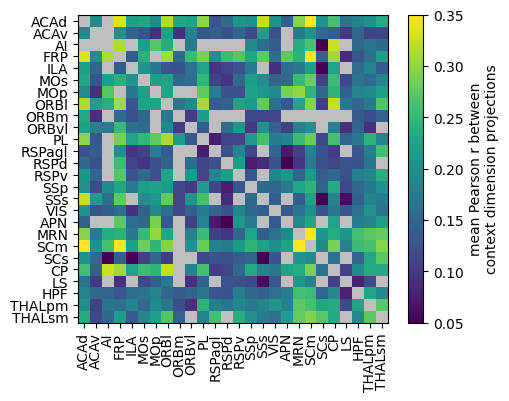

In [95]:
sel_projection_type='task_corrected'
# sel_projection_type='spont'

fig,ax=plt.subplots(1,1,figsize=(5,4))

masked_array = np.ma.array(corr_matrix_dict[sel_projection_type], mask=np.isnan(corr_matrix_dict[sel_projection_type]))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

im=ax.imshow(np.abs(masked_array), aspect='auto', cmap=cmap, vmin=0.05, vmax=0.35, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
ax.set_xticks(np.arange(len(incl_structures)), incl_structures, rotation=90)
ax.set_yticks(np.arange(len(incl_structures)), incl_structures)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between\ncontext dimension projections')

In [96]:
# custom_order=[
#     'ACAd', 'ACAv', 'AI', 'FRP', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PL',
#     'RSPagl', 'RSPd', 'RSPv', 'SSp', 'SSs', 'VIS', 'AUD',
#     'APN', 'MRN', 'SCm', 'SCs',
#     'CP', 'BG', 'LS',
#     'HPF', 
#     'THALpm', 'THALsm',
# ]

custom_order=[
    'ACAd', 'ACAv', 'AI', 'FRP', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PL',
    'RSPagl', 'RSPd', 'RSPv', 'SSp', 'SSs', 'VIS',
    'APN', 'MRN', 'SCm', 'SCs',
    'CP', 'LS',
    'HPF', 
    'THALpm', 'THALsm',
]

custom_order_index=np.arange(len(custom_order),dtype=int)

custom_order_pd = pd.DataFrame({
    'structure': custom_order,
    'index': custom_order_index
})

custom_order_pd


,structure,index
0,ACAd,0
1,ACAv,1
2,AI,2
3,FRP,3
4,ILA,4
5,MOp,5
6,MOs,6
7,ORBl,7
8,ORBm,8
9,ORBvl,9


In [107]:
#cluster the correlation matrix
from sklearn.cluster import SpectralCoclustering
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import consensus_score

sel_projection_type='task_corrected'

corr_matrix=corr_matrix_dict[sel_projection_type].copy()

cluster_corr_matrix=np.abs(corr_matrix_dict[sel_projection_type].copy())

cluster_corr_matrix[np.isnan(cluster_corr_matrix)]=np.nanmean(cluster_corr_matrix)

data=cluster_corr_matrix.copy()

model = SpectralBiclustering(n_clusters=2, method="log", random_state=0,)# svd_method='arpack', n_init=25)
# model = SpectralCoclustering(n_clusters=2, random_state=0)
model.fit(data)

#switch cluster order?
switch_cluster_order=None
if switch_cluster_order is not None:
    model.row_labels_ = np.array([switch_cluster_order[label] for label in model.row_labels_])
    model.column_labels_ = np.array([switch_cluster_order[label] for label in model.column_labels_])

custom_order_pd_copy=custom_order_pd.copy()

custom_incl_structures=True

if custom_incl_structures:
    custom_order_pd_copy['cluster'] = model.row_labels_
    custom_order_pd_copy.sort_values(by=['cluster', 'index'], inplace=True)
    sort_idx=custom_order_pd_copy.index.values
    fit_data = corr_matrix[sort_idx]
    fit_data = fit_data[:, sort_idx]
    
else:
    sort_idx = np.argsort(model.row_labels_)
    fit_data = corr_matrix[sort_idx]
    fit_data = fit_data[:, sort_idx]

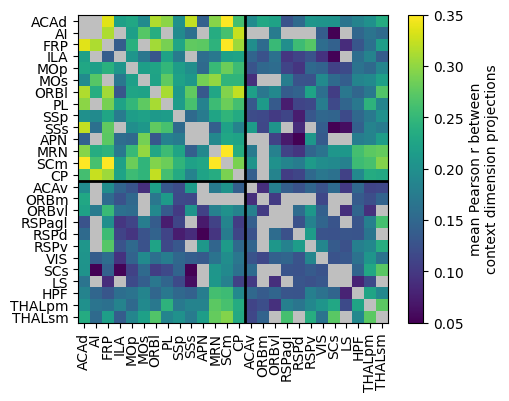

In [109]:
structure_labels=custom_order_pd['structure'].values[sort_idx]

masked_array = np.ma.array(fit_data, mask=np.isnan(fit_data))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(5,4))
im=ax.imshow(np.abs(masked_array), aspect='auto', cmap=cmap, vmin=0.05, vmax=0.35, extent=[-0.5,len(structure_labels)-0.5,len(structure_labels)-0.5,-0.5])
ax.set_xticks(np.arange(len(structure_labels)), np.array(structure_labels), rotation=90)
ax.set_yticks(np.arange(len(structure_labels)), np.array(structure_labels))

row_labels = model.row_labels_
sorted_row_labels = row_labels[sort_idx]
cluster_borders = np.where(np.diff(sorted_row_labels) != 0)[0] + 0.5

for xx in cluster_borders:
    ax.axvline(x=xx, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=xx, color='black', linestyle='-', linewidth=2)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between\ncontext dimension projections')

# ax.set_title(f'Spectral biclustering of ')

In [110]:
#save figure
savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-12-01-plots_for_DR_PAC\LDA_task_corrected_context_projection_corr_0.05-0.35.png'
fig.savefig(savepath, bbox_inches='tight', dpi=300,
            transparent=True, format='png', pad_inches=0.1)

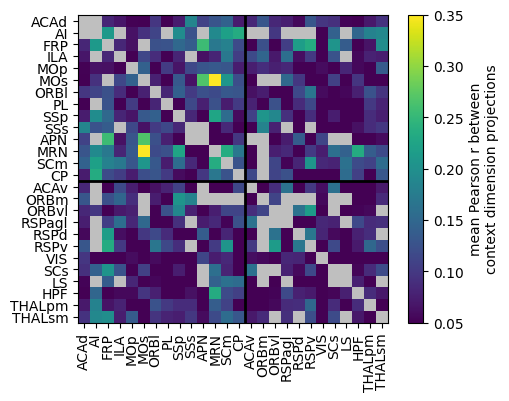

In [111]:
#plot spontaneous correlation matrix with same ordering
sorted_spont_data = corr_matrix_dict['spont'][sort_idx]
sorted_spont_data = sorted_spont_data[:, sort_idx]
structure_labels=custom_order_pd['structure'].values[sort_idx]

masked_array = np.ma.array(sorted_spont_data, mask=np.isnan(sorted_spont_data))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(5,4))
im=ax.imshow(np.abs(masked_array), aspect='auto', cmap=cmap, vmin=0.05, vmax=0.35, extent=[-0.5,len(structure_labels)-0.5,len(structure_labels)-0.5,-0.5])
ax.set_xticks(np.arange(len(structure_labels)), np.array(structure_labels), rotation=90)
ax.set_yticks(np.arange(len(structure_labels)), np.array(structure_labels))

row_labels = model.row_labels_
sorted_row_labels = row_labels[sort_idx]
cluster_borders = np.where(np.diff(sorted_row_labels) != 0)[0] + 0.5

for xx in cluster_borders:
    ax.axvline(x=xx, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=xx, color='black', linestyle='-', linewidth=2)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between\ncontext dimension projections')

In [112]:
#save figure
savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-12-01-plots_for_DR_PAC\LDA_spont_context_projection_corr_0.05-0.35.png'
fig.savefig(savepath, bbox_inches='tight', dpi=300,
            transparent=True, format='png', pad_inches=0.1)